In [1]:
from shapely.geometry import Point, Polygon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

### Read Sampling Point details

In [2]:
df = pd.read_csv ('water_use.csv')
water_df = df[['sample.samplingPoint.notation','sample.samplingPoint.label','sample.sampledMaterialType.label','sample.samplingPoint.easting','sample.samplingPoint.northing']]
water_df = water_df.drop_duplicates(subset=['sample.samplingPoint.notation'])
water_df = water_df.reset_index(drop=True)

In [3]:
# Function to transform Easting, Northing to Longitude and Latitude
from pyproj import Proj, transform

v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy",
        towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")

def dfENtoLL84(df):
    """Returns (longitude, latitude) tuple
    """
    vlon36, vlat36 = vgrid(df["sample.samplingPoint.easting"].values, df["sample.samplingPoint.northing"].values, inverse=True)
    result = transform(v36, v84, vlon36, vlat36)

    # Transform the output to a Dataframe
    latlong = pd.DataFrame(index=df.index)

    for i in result:
        latlong["lon"] = result[0]
        latlong["lat"] = result[1]
    
    return latlong

latlong_df = dfENtoLL84(water_df)

/rds/general/user/xh1119/home/anaconda3/envs/tsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-3-a52137f65a79>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  result = transform(v36, v84, vlon36, vlat36)


In [4]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(latlong_df.lon, latlong_df.lat)]
water_pt = gpd.GeoSeries(geometry, name='water_pt')
water_df = water_df.merge(water_pt,left_index=True, right_index=True)

In [5]:
water_type = water_df['sample.sampledMaterialType.label']

River =  gpd.GeoDataFrame(water_df[water_type.str.contains('RIVER')])
Lake = gpd.GeoDataFrame(water_df[water_type.str.contains('LAKE')])
Estury = gpd.GeoDataFrame(water_df[water_type.str.contains('ESTU')])
Ground = gpd.GeoDataFrame(water_df[water_type.str.contains('GRO')])
Mine = gpd.GeoDataFrame(water_df[water_type.str.contains('MINE')])

### Visualise different water sources in England on a map

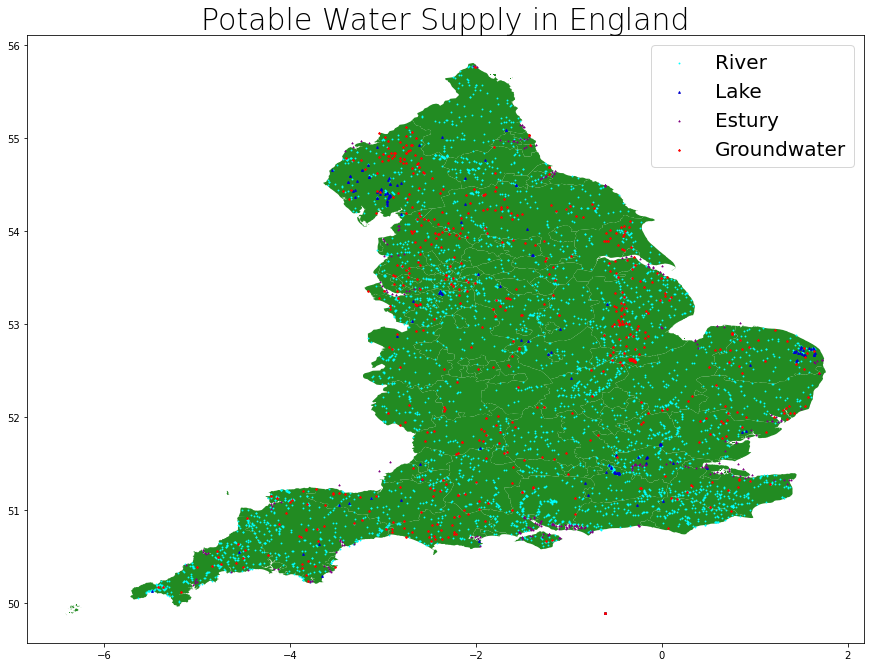

In [6]:
uk_land = gpd.read_file('uk/gadm36_GBR_2.shp')
England = uk_land.loc[uk_land['NAME_1']=='England']
minx, miny, maxx, maxy = England.total_bounds

fig, ax = plt.subplots(1, figsize = (15,30))
ax.axes.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

England.plot(ax=ax,alpha=1, color='forestgreen')
River['water_pt'].plot(ax=ax, markersize=3, color='aqua',marker='.')
Lake['water_pt'].plot(ax=ax, markersize=3, color='mediumblue',marker='^')
Estury['water_pt'].plot(ax=ax, markersize=3, color='purple',marker='1')
Ground['water_pt'].plot(ax=ax, markersize=3, color='red',marker='*')

plt.legend(['River','Lake','Estury','Groundwater'],prop={'size': 20})
plt.axis('scaled')
ax.set_title('Potable Water Supply in England', fontdict={'fontsize': '30', 'fontweight': '3'})
plt.savefig('wat_sup.png')

### Calculate distance and identify closest water sources

Enter your real-time location:


 51.512370098779, -0.18771530467905798




THE CLOSEST WATER SUPPLY IS 1.54 KM AWAY AT BATHING WATER - THE SERPENTINE (11940) 

THE COORDINATE IS [51.5049037  -0.16909514] IT IS POND / LAKE / RESERVOIR WATER


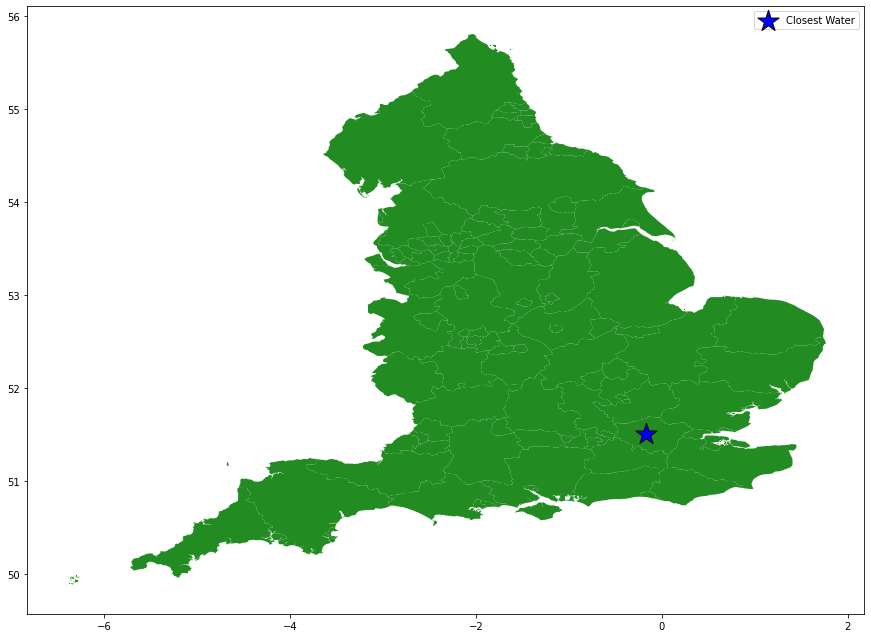

In [13]:
import geopy.distance

distance = []
coords = latlong_df[["lat", "lon"]].to_numpy()
print("Enter your real-time location:")
location = [input()]

for i in range(len(coords)):
    coords_1 = coords[i]
    coords_2 = location
    distance.append(geopy.distance.geodesic(coords_1, coords_2).km)

index_min = min(range(len(distance)), key=distance.__getitem__)
dist_min = round(distance[index_min],2)
closest_water = water_df.iloc[index_min]

print("\n")
print("THE CLOSEST WATER SUPPLY IS",dist_min,"KM AWAY AT",closest_water['sample.samplingPoint.label'],"\n")
print("THE COORDINATE IS",coords[index_min],"IT IS",closest_water["sample.sampledMaterialType.label"])     
      

fig, ax = plt.subplots(1, figsize = (15,30))
ax.axes.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

England.plot(ax=ax,alpha=1, color='forestgreen')
ax.scatter(x=closest_water['water_pt'].x, y=closest_water['water_pt'].y, s=500, color='b', marker='*', edgecolor='black', label='Closest Water')

plt.axis('scaled')
legend = ax.legend()

### Identify army bases for further usage

In [13]:
base_df = pd.read_csv('local.csv')

In [14]:
geometry = [Point(xy) for xy in zip(base_df.lon, base_df.lat)]
army_pt = gpd.GeoSeries(geometry, name='army_pt')
base_df = base_df.merge(army_pt,left_index=True, right_index=True)

In [15]:
base_df = gpd.GeoDataFrame(base_df)

In [16]:
base_df

,Base name,lat,lon,army_pt
0,retired benefits,51.480362,-0.100889,POINT (-0.10089 51.48036)
1,the armed forces,51.530070,-0.122241,POINT (-0.12224 51.53007)
2,Royal green jackets,51.517050,-0.148027,POINT (-0.14803 51.51705)
3,London Regiment TA centre,51.468877,-0.170329,POINT (-0.17033 51.46888)
4,army reserve centre Marlow,51.683114,-0.780877,POINT (-0.78088 51.68311)
5,ATC pirbright,51.416345,-0.706761,POINT (-0.70676 51.41634)
6,Army,54.648281,-1.903938,POINT (-1.90394 54.64828)
7,"4th battalion, the duke of lancaster's regiment",53.522418,-2.192220,POINT (-2.19222 53.52242)
8,C company 3rd battalion,51.680369,-3.292385,POINT (-3.29239 51.68037)
9,RAF Pembrey,51.753651,-4.285702,POINT (-4.28570 51.75365)


Text(0.5, 1.0, 'Army Base in the UK')

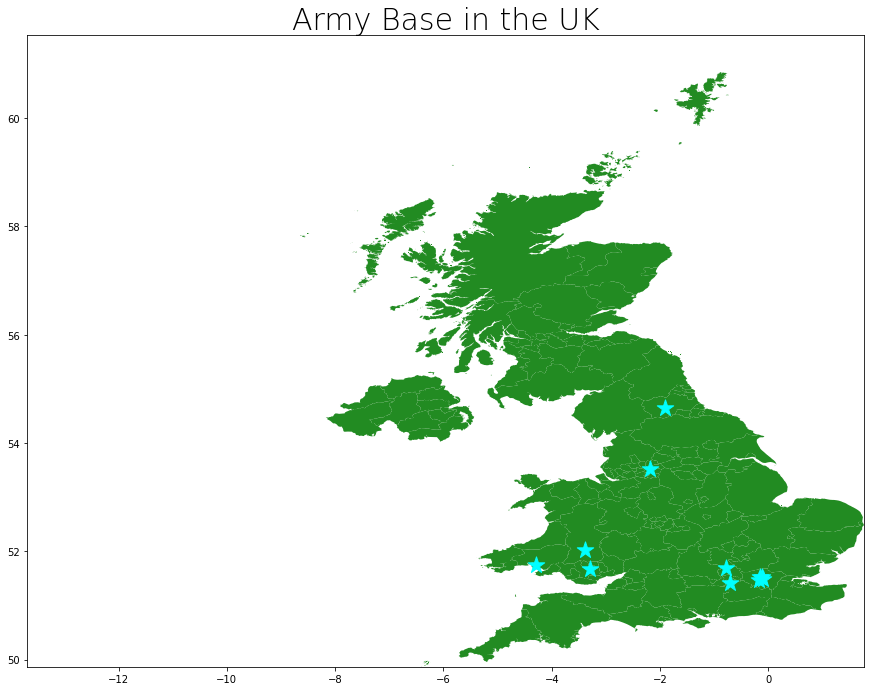

In [17]:
minx, miny, maxx, maxy = uk_land.total_bounds
fig, ax = plt.subplots(1, figsize = (15,30))
ax.axes.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

uk_land.plot(ax=ax,alpha=1, color='forestgreen')
base_df['army_pt'].plot(ax=ax, markersize=300, color='aqua',marker='*')
ax.set_title('Army Base in the UK', fontdict={'fontsize': '30', 'fontweight': '3'})

Enter your real-time location:


 51.465133027661125, -0.1115298664499265





The cloest base is 1.85 Km away at retired benefits 


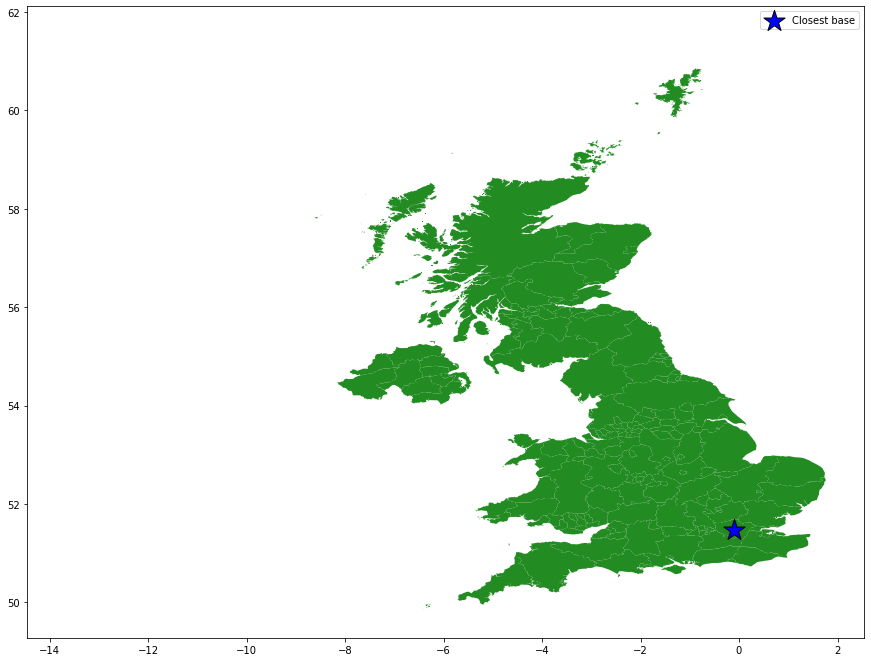

In [18]:
distance = []
coords = base_df[["lat", "lon"]].to_numpy()
print("Enter your real-time location:")
location = [input()]

for i in range(len(coords)):
    coords_1 = coords[i]
    coords_2 = location
    distance.append(geopy.distance.geodesic(coords_1, coords_2).km)

index_min = min(range(len(distance)), key=distance.__getitem__)
dist_min = round(distance[index_min],2)
closest_base = base_df.iloc[index_min]
print("\n"*2)
print("The cloest base is",dist_min,"Km away at",closest_base['Base name'])

fig, ax = plt.subplots(1, figsize = (15,30))
ax.axes.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

uk_land.plot(ax=ax,alpha=1, color='forestgreen')
ax.scatter(x=closest_base['army_pt'].x, y=closest_base['army_pt'].y, s=500, color='b', marker='*', edgecolor='black', label='Closest base')

plt.axis('scaled')
legend = ax.legend()